##Install Library and preparing

In [1]:
!pip install torch
!pip install tf
!pip install -q gdown
!pip install transformers[torch] accelerate -U
!pip install accelerate -U
!pip install datasets
!pip install gensim
!pip install evaluate

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from collections import Counter
import tensorflow as tf
from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModelForSequenceClassification,Trainer, AutoConfig, TrainingArguments, EarlyStoppingCallback
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Dense, Flatten, concatenate, BatchNormalization,LSTM, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from evaluate import load
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import he_normal
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import BorderlineSMOTE,KMeansSMOTE,SVMSMOTE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.1 MB/s eta 0:00:00


###Read Dataset and load Word2Vec

In [2]:
df = pd.read_csv("/content/news_train_balanced_clean.csv")

In [3]:
df_test1 = pd.read_csv("/content/news_test_clean.csv")
# df_test2 = pd.read_csv("test_data_2.csv")
# df_test3 = pd.read_csv("test_data_3.csv")

In [4]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
gc.collect()
print(gensim.__version__)
# Load Pretrained Word Embeddings (Word2Vec)
!gdown --id 1QYj5FruufaPq2mZgC6lZlq2Uw2E004Og
!gdown --id 1F9QsHO7FPIPq3nL_I0zCkZFvq3OVcJrB
!gdown --id 1VUjxpH10baOw439V-YAAVVbtyI8iLgG5

4.4.0
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1QYj5FruufaPq2mZgC6lZlq2Uw2E004Og
To: /content/idwiki_word2vec_768_new_lower.model
100% 14.4M/14.4M [00:00<00:00, 69.9MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1F9QsHO7FPIPq3nL_I0zCkZFvq3OVcJrB
From (redirected): https://drive.google.com/uc?id=1F9QsHO7FPIPq3nL_I0zCkZFvq3OVcJrB&confirm=t&uuid=4c2704ac-2c88-488a-8115-7076089a7d25
To: /content/idwiki_word2vec_768_new_lower.model.syn1neg.npy
100% 1.37G/1.37G [00:08<00:00, 164MB/s]
/usr/local/lib/python3.12/dist-packages/gd

In [5]:
# import os
# import gdown
# import zipfile

# '''https://drive.google.com/file/d/1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3/view?usp=sharing'''

# file_id = '1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3'

# url = f'https://drive.google.com/uc?id={file_id}'
# output_zip = 'model_w2v.zip'

# if not os.path.exists('idwiki_word2vec_768_new_lower.model'):
#     print("Downloading Model...")
#     gdown.download(url, output_zip, quiet=False)

#     print("Extracting File...")
#     with zipfile.ZipFile(output_zip, 'r') as zip_ref:
#         zip_ref.extractall('/content/')
#     print("Done.")
# else:
#     print("Model Available")

In [6]:
word_embeddings = Word2Vec.load('/content/idwiki_word2vec_768_new_lower.model')
#word_embeddings = Word2Vec.load('/content/modelword2vec/idwiki_word2vec_768_new_lower.model')

###Split Dataset

In [7]:
x_train = df['Text']
y_train = df['Label']

In [8]:
x_test1 = df_test1['Text']
y_test1 = np.array(df_test1['Label'])

In [9]:
# x_test2 = df_test2['Text']
# y_test2 = np.array(df_test2['Label'])

In [10]:
# x_test3 = df_test3['Text']
# y_test3 = np.array(df_test3['Label'])

###Define Loss Function, Tokenization, Word Embeddings and Oversampling

In [11]:
# # Define the margin loss function
# def margin_loss(y_true, y_pred):
#     margin = K.constant(0.1)
#     y_true_float = K.cast(y_true, dtype='float32')  # Convert y_true to float32
#     squared_difference_pos = K.square(K.maximum(0.9 - y_pred, 0))
#     squared_difference_neg = K.square(K.maximum(y_pred - 0.1, 0))
#     loss_pos = K.mean(y_true_float * squared_difference_pos)
#     loss_neg = K.mean((1 - y_true_float) * squared_difference_neg)
#     total_loss = loss_pos + lambda_val * loss_neg
#     return total_loss

In [12]:
# Define the model architectures
#embedding_dim = 300
#max_sequence_length = 100
# lambda_val = 0.7  # Lambda value for margin loss
#num_words = 100000

In [13]:
# Create word index
word_index = {word: index + 1 for index, word in enumerate(word_embeddings.wv.index_to_key)}

# Create embedding matrix
embedding_dim = word_embeddings.vector_size
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word_embeddings.wv:
        embedding_vector = word_embeddings.wv[word]
        embedding_matrix[i] = embedding_vector


In [14]:
# Tokenization
tokenizer = Tokenizer(num_words=len(word_index) + 1, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train.astype(str))

# Convert text to sequences and pad
x_train_sequences = tokenizer.texts_to_sequences(x_train.astype(str))
# Convert all values in x_test1 to string before tokenization
x_test_sequences1 = tokenizer.texts_to_sequences(x_test1.astype(str))

# Determine max sequence length based on your data
max_sequence_length = max(max(len(seq) for seq in x_train_sequences), max(len(seq) for seq in x_test_sequences1))

x_train_padded = pad_sequences(x_train_sequences, maxlen=max_sequence_length, padding='post')
x_test_padded1 = pad_sequences(x_test_sequences1, maxlen=max_sequence_length, padding='post')

In [15]:
x_train_flat = x_train_padded.reshape(x_train_padded.shape[0], -1)

####Oversampling with BorderlineSMOTE

In [16]:
borderline_smote = BorderlineSMOTE(random_state=42)
x_train_resampled_flat_borderline, y_train_resampled_borderline = borderline_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_borderline = x_train_resampled_flat_borderline.reshape(x_train_resampled_flat_borderline.shape[0], max_sequence_length)

####Oversampling with KMeansSMOTE

In [17]:
kmeans_smote = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.2)
x_train_resampled_flat_kmeans, y_train_resampled_kmeans = kmeans_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_kmeans = x_train_resampled_flat_kmeans.reshape(x_train_resampled_flat_kmeans.shape[0], max_sequence_length)

####Oversampling with SVMSMOTE

In [18]:
svm_smote = SVMSMOTE(random_state=42)
x_train_resampled_flat_svm, y_train_resampled_svm = svm_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_svm = x_train_resampled_flat_svm.reshape(x_train_resampled_flat_svm.shape[0], max_sequence_length)

In [19]:
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [20]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


##CNN + LSTM

In [21]:
# Define the architecture of the hybrid model with he_normal initialization
static_input = Input(shape=(max_sequence_length,))
static_embedding = Embedding(len(word_index) + 1, embedding_dim, input_length=max_sequence_length, trainable=False)(static_input)  # Removed weights parameter

# CNN Layers
static_cnn_output = Conv1D(128, 3, activation='relu', kernel_initializer=he_normal())(static_embedding)  # Use he_normal initialization
static_cnn_output = MaxPooling1D(2)(static_cnn_output)
static_cnn_output = GlobalMaxPooling1D()(static_cnn_output)
static_cnn_output = Dropout(0.5)(static_cnn_output)
batch_norm_layer_cnn = BatchNormalization()(static_cnn_output)

# LSTM Layer
static_lstm_output = LSTM(128, kernel_initializer=he_normal())(static_embedding)  # Use he_normal initialization
static_lstm_output = Dropout(0.5)(static_lstm_output)
batch_norm_layer_lstm = BatchNormalization()(static_lstm_output)

# Concatenate CNN and LSTM outputs
merged_layer = tf.keras.layers.concatenate([batch_norm_layer_cnn, batch_norm_layer_lstm], axis=-1)

# Fully Connected Layers
static_dense_output = Dense(128, activation='relu', kernel_initializer=he_normal())(merged_layer)  # Use he_normal initialization
static_dense_output = Dropout(0.5)(static_dense_output)
output = Dense(1, activation='sigmoid')(static_dense_output)

# Create the hybrid model
hybrid_model = Model(inputs=static_input, outputs=output)
hybrid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


###CNN + LSTM BorderlineSMOTE Train and Test

In [ ]:
# Train the CNN + LSTM model
epochs_hybrid = 10
history_hybrid_borderline = hybrid_model.fit(
    x_train_resampled_borderline,
    y_train_resampled_borderline,
    batch_size=128,
    epochs=epochs_hybrid,
    validation_split=0.1,
)



Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 88s 300ms/step - accuracy: 0.8334 - loss: 0.3735 - val_accuracy: 0.9984 - val_loss: 0.1183
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 292ms/step - accuracy: 0.9886 - loss: 0.0367 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 293ms/step - accuracy: 0.9957 - loss: 0.0180 - val_accuracy: 1.0000 - val_loss: 3.6930e-04
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 293ms/step - accuracy: 0.9972 - loss: 0.0127 - val_accuracy: 1.0000 - val_loss: 6.4346e-04
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 294ms/step - accuracy: 0.9978 - loss: 0.0105 - val_accuracy: 1.0000 - val_loss: 3.3243e-04
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 294ms/step - accuracy: 0.9976 - loss: 0.0107 - val_accuracy: 1.0000 - val_loss: 2.0305e-04
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 294ms/step - accuracy: 0.9984 - loss: 0.0106 - val_accuracy: 1.0000 - val_loss: 2.2771e-04
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 294ms/step - accura

In [ ]:
# Convert the data to numpy arrays
x_train_np = np.array(x_train_resampled_borderline)
y_train_np = np.array(y_train_resampled_borderline)

In [ ]:
from sklearn.model_selection import KFold
# Define the number of folds
num_folds = 10

# Initialize K-Fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # You can set a random seed for reproducibility

# Initialize lists to store cross-validation results
accuracies = []
losses = []


In [ ]:
# Initialize lists to store training and validation accuracies and losses
train_accuracies_hybrid = []
val_accuracies_hybrid = []
train_losses_hybrid = []
val_losses_hybrid = []
classification_reports_hybrid = []
# Iterate over the folds
fold = 0
for train_indices, val_indices in kf.split(x_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds}")

    hybrid_model = Model(inputs=static_input, outputs=output)

    hybrid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Get the training and validation data for this fold
    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Early stopping callback
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    # Train the model for this fold
    history = hybrid_model.fit(
        x_train_fold,
        y_train_fold,
        batch_size=128,
        epochs=epochs_hybrid,  # Make sure you define epochs_hybrid
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
    )

    # Evaluate the model on this fold for training and validation
    train_loss_hybrid, train_accuracy_hybrid = hybrid_model.evaluate(x_train_fold, y_train_fold)
    val_loss_hybrid, val_accuracy_hybrid = hybrid_model.evaluate(x_val_fold, y_val_fold)

    print(f"Fold {fold} - Training Loss: {train_loss_hybrid}, Training Accuracy: {train_accuracy_hybrid}")
    print(f"Fold {fold} - Validation Loss: {val_loss_hybrid}, Validation Accuracy: {val_accuracy_hybrid}")

    # Store the results for this fold
    train_accuracies_hybrid.append(train_accuracy_hybrid)
    val_accuracies_hybrid.append(val_accuracy_hybrid)
    train_losses_hybrid.append(train_loss_hybrid)
    val_losses_hybrid.append(val_loss_hybrid)

    # Evaluate the model
    y_pred = (hybrid_model.predict(x_val_fold) > 0.5).astype("int32").flatten()

    # Generate and store the classification report
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports_hybrid.append(report)

    # Print the classification report for this fold
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)



Training fold 1/10
Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 83s 303ms/step - accuracy: 0.9982 - loss: 0.0089 - val_accuracy: 0.9995 - val_loss: 0.0045
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 293ms/step - accuracy: 0.9982 - loss: 0.0091 - val_accuracy: 0.9992 - val_loss: 0.0047
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 294ms/step - accuracy: 0.9987 - loss: 0.0082 - val_accuracy: 0.9992 - val_loss: 0.0053
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 293ms/step - accuracy: 0.9986 - loss: 0.0077 - val_accuracy: 0.9992 - val_loss: 0.0066
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 56s 52ms/step - accuracy: 0.9989 - loss: 0.0087
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.9993 - loss: 0.0056
Fold 1 - Training Loss: 0.005417895037680864, Training Accuracy: 0.9992936253547668
Fold 1 - Validation Loss: 0.0045160469599068165, Validation Accuracy: 0.9994701743125916
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step
              precision    recall  f1-score   support

           0       1.00      1.0

In [ ]:
# Calculate and print the mean and standard deviation of training accuracy and loss across folds
mean_train_accuracy = sum(train_accuracies_hybrid) / num_folds
std_train_accuracy = (sum([(acc - mean_train_accuracy) ** 2 for acc in train_accuracies_hybrid]) / num_folds) ** 0.5
mean_train_loss = sum(train_losses_hybrid) / num_folds
std_train_loss = (sum([(loss - mean_train_loss) ** 2 for loss in train_losses_hybrid]) / num_folds) ** 0.5
print(f"Mean Training Accuracy: {mean_train_accuracy}, Std Training Accuracy: {std_train_accuracy}")
print(f"Mean Training Loss: {mean_train_loss}, Std Training Loss: {std_train_loss}")

# Calculate and print the mean and standard deviation of validation accuracy and loss across folds
mean_val_accuracy = sum(val_accuracies_hybrid) / num_folds
std_val_accuracy = (sum([(acc - mean_val_accuracy) ** 2 for acc in val_accuracies_hybrid]) / num_folds) ** 0.5
mean_val_loss = sum(val_losses_hybrid) / num_folds
std_val_loss = (sum([(loss - mean_val_loss) ** 2 for loss in val_losses_hybrid]) / num_folds) ** 0.5
print(f"Mean Validation Accuracy: {mean_val_accuracy}, Std Validation Accuracy: {std_val_accuracy}")
print(f"Mean Validation Loss: {mean_val_loss}, Std Validation Loss: {std_val_loss}")

Mean Training Accuracy: 0.999358344078064, Std Training Accuracy: 4.889567628488717e-05
Mean Training Loss: 0.004609940107911825, Std Training Loss: 0.00044305149268906004
Mean Validation Accuracy: 0.9993642330169678, Std Validation Accuracy: 0.0003964716992852376
Mean Validation Loss: 0.004496710118837654, Std Validation Loss: 0.0024264167370921484


In [ ]:
avg_report_hybrid = {
    'Class 0': {
        'precision': np.mean([r['0']['precision'] for r in classification_reports_hybrid]),
        'recall': np.mean([r['0']['recall'] for r in classification_reports_hybrid]),
        'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_hybrid]),
        'support': np.sum([r['0']['support'] for r in classification_reports_hybrid])
    },
    'Class 1': {
        'precision': np.mean([r['1']['precision'] for r in classification_reports_hybrid]),
        'recall': np.mean([r['1']['recall'] for r in classification_reports_hybrid]),
        'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_hybrid]),
        'support': np.sum([r['1']['support'] for r in classification_reports_hybrid])
    }
}

# Print the aggregated classification report
print("Average Classification Report across all folds:")
print(avg_report_hybrid)

Average Classification Report across all folds:
{'Class 0': {'precision': np.float64(1.0), 'recall': np.float64(0.9987234248859126), 'f1-score': np.float64(0.9993611427719149), 'support': np.float64(18875.0)}, 'Class 1': {'precision': np.float64(0.9987352923500525), 'recall': np.float64(1.0), 'f1-score': np.float64(0.999367093800204), 'support': np.float64(18875.0)}}


In [ ]:
import csv

# Define the file name for saving the metrics
csv_file = 'metrics_hybrid_borderline.csv'

headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']

# Combine training and validation metrics into a single list
all_metrics = []


# Collect the metrics and populate the data
for epoch in range(epochs_hybrid):
    # Training metrics for the current epoch
    train_loss = history_hybrid_borderline.history['loss'][epoch]
    train_accuracy = history_hybrid_borderline.history['accuracy'][epoch]

    # Validation metrics for the current epoch
    val_loss = history_hybrid_borderline.history['val_loss'][epoch]
    val_accuracy = history_hybrid_borderline.history['val_accuracy'][epoch]

    # Append the metrics for the current epoch
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

# Write the metrics to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the headers
    writer.writerow(headers)

    # Write the data
    writer.writerows(all_metrics)

####Testing

In [ ]:
hybrid_evaluation1 = hybrid_model.evaluate(x_test_padded1, y_test1, batch_size=4)
hybrid_accuracy1 = hybrid_evaluation1[1]

print("Hybrid Model Evaluation Results:")
print("Accuracy:", hybrid_accuracy1)

551/551 ━━━━━━━━━━━━━━━━━━━━ 32s 57ms/step - accuracy: 0.9877 - loss: 0.0435
Hybrid Model Evaluation Results:
Accuracy: 0.9854611754417419


In [ ]:
y_test_pred1 = (hybrid_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2097
           1       0.82      0.88      0.85       104

    accuracy                           0.99      2201
   macro avg       0.91      0.94      0.92      2201
weighted avg       0.99      0.99      0.99      2201



###CNN + LSTM KMeansSMOTE Train and Test

In [ ]:
hybrid_model = Model(inputs=static_input, outputs=output)
hybrid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the CNN + LSTM model
epochs_hybrid = 10
history_hybrid_kmeans = hybrid_model.fit(
    x_train_resampled_kmeans,
    y_train_resampled_kmeans,
    batch_size=128,
    epochs=epochs_hybrid,
    validation_split=0.1,
)



Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 81s 294ms/step - accuracy: 0.9988 - loss: 0.0081 - val_accuracy: 1.0000 - val_loss: 4.4843e-04
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 293ms/step - accuracy: 0.9992 - loss: 0.0053 - val_accuracy: 1.0000 - val_loss: 2.8451e-04
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 294ms/step - accuracy: 0.9990 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 4.4913e-04
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 294ms/step - accuracy: 0.9993 - loss: 0.0053 - val_accuracy: 1.0000 - val_loss: 4.2958e-04
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 294ms/step - accuracy: 0.9991 - loss: 0.0056 - val_accuracy: 1.0000 - val_loss: 6.4278e-04
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 294ms/step - accuracy: 0.9992 - loss: 0.0063 - val_accuracy: 1.0000 - val_loss: 4.1841e-04
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 294ms/step - accuracy: 0.9988 - loss: 0.0081 - val_accuracy: 1.0000 - val_loss: 4.4182e-04
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 294ms/step 

In [ ]:
# Convert the data to numpy arrays
x_train_np = np.array(x_train_resampled_kmeans)
y_train_np = np.array(y_train_resampled_kmeans)

In [ ]:
from sklearn.model_selection import KFold
# Define the number of folds
num_folds = 10

# Initialize K-Fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # You can set a random seed for reproducibility

# Initialize lists to store cross-validation results
accuracies = []
losses = []


In [ ]:
# Initialize lists to store training and validation accuracies and losses
train_accuracies_hybrid = []
val_accuracies_hybrid = []
train_losses_hybrid = []
val_losses_hybrid = []
classification_reports_hybrid = []
# Iterate over the folds
fold = 0
for train_indices, val_indices in kf.split(x_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds}")

    hybrid_model = Model(inputs=static_input, outputs=output)

    hybrid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Get the training and validation data for this fold
    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Early stopping callback
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    # Train the model for this fold
    history = hybrid_model.fit(
        x_train_fold,
        y_train_fold,
        batch_size=128,
        epochs=epochs_hybrid,  # Make sure you define epochs_hybrid
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
    )

    # Evaluate the model on this fold for training and validation
    train_loss_hybrid, train_accuracy_hybrid = hybrid_model.evaluate(x_train_fold, y_train_fold)
    val_loss_hybrid, val_accuracy_hybrid = hybrid_model.evaluate(x_val_fold, y_val_fold)

    print(f"Fold {fold} - Training Loss: {train_loss_hybrid}, Training Accuracy: {train_accuracy_hybrid}")
    print(f"Fold {fold} - Validation Loss: {val_loss_hybrid}, Validation Accuracy: {val_accuracy_hybrid}")

    # Store the results for this fold
    train_accuracies_hybrid.append(train_accuracy_hybrid)
    val_accuracies_hybrid.append(val_accuracy_hybrid)
    train_losses_hybrid.append(train_loss_hybrid)
    val_losses_hybrid.append(val_loss_hybrid)

    # Evaluate the model
    y_pred = (hybrid_model.predict(x_val_fold) > 0.5).astype("int32").flatten()

    # Generate and store the classification report
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports_hybrid.append(report)

    # Print the classification report for this fold
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)



Training fold 1/10
Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 84s 301ms/step - accuracy: 0.9992 - loss: 0.0066 - val_accuracy: 0.9995 - val_loss: 0.0039
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 79s 297ms/step - accuracy: 0.9989 - loss: 0.0066 - val_accuracy: 0.9995 - val_loss: 0.0037
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 294ms/step - accuracy: 0.9993 - loss: 0.0051 - val_accuracy: 0.9995 - val_loss: 0.0038
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 294ms/step - accuracy: 0.9994 - loss: 0.0047 - val_accuracy: 0.9995 - val_loss: 0.0038
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 294ms/step - accuracy: 0.9993 - loss: 0.0049 - val_accuracy: 0.9995 - val_loss: 0.0039
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 55s 52ms/step - accuracy: 0.9989 - loss: 0.0067
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9993 - loss: 0.0042
Fold 1 - Training Loss: 0.004417647607624531, Training Accuracy: 0.9993524551391602
Fold 1 - Validation Loss: 0.0037144608795642853, Validation Accuracy: 0.999470174312591

In [ ]:
# Calculate and print the mean and standard deviation of training accuracy and loss across folds
mean_train_accuracy = sum(train_accuracies_hybrid) / num_folds
std_train_accuracy = (sum([(acc - mean_train_accuracy) ** 2 for acc in train_accuracies_hybrid]) / num_folds) ** 0.5
mean_train_loss = sum(train_losses_hybrid) / num_folds
std_train_loss = (sum([(loss - mean_train_loss) ** 2 for loss in train_losses_hybrid]) / num_folds) ** 0.5
print(f"Mean Training Accuracy: {mean_train_accuracy}, Std Training Accuracy: {std_train_accuracy}")
print(f"Mean Training Loss: {mean_train_loss}, Std Training Loss: {std_train_loss}")

# Calculate and print the mean and standard deviation of validation accuracy and loss across folds
mean_val_accuracy = sum(val_accuracies_hybrid) / num_folds
std_val_accuracy = (sum([(acc - mean_val_accuracy) ** 2 for acc in val_accuracies_hybrid]) / num_folds) ** 0.5
mean_val_loss = sum(val_losses_hybrid) / num_folds
std_val_loss = (sum([(loss - mean_val_loss) ** 2 for loss in val_losses_hybrid]) / num_folds) ** 0.5
print(f"Mean Validation Accuracy: {mean_val_accuracy}, Std Validation Accuracy: {std_val_accuracy}")
print(f"Mean Validation Loss: {mean_val_loss}, Std Validation Loss: {std_val_loss}")

Mean Training Accuracy: 0.9993642270565033, Std Training Accuracy: 4.4054447785203437e-05
Mean Training Loss: 0.004362036124803126, Std Training Loss: 0.00031077930125690664
Mean Validation Accuracy: 0.9993642330169678, Std Validation Accuracy: 0.0003964716992852376
Mean Validation Loss: 0.004244922264479101, Std Validation Loss: 0.0022908721400858307


In [ ]:
avg_report_hybrid = {
    'Class 0': {
        'precision': np.mean([r['0']['precision'] for r in classification_reports_hybrid]),
        'recall': np.mean([r['0']['recall'] for r in classification_reports_hybrid]),
        'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_hybrid]),
        'support': np.sum([r['0']['support'] for r in classification_reports_hybrid])
    },
    'Class 1': {
        'precision': np.mean([r['1']['precision'] for r in classification_reports_hybrid]),
        'recall': np.mean([r['1']['recall'] for r in classification_reports_hybrid]),
        'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_hybrid]),
        'support': np.sum([r['1']['support'] for r in classification_reports_hybrid])
    }
}

# Print the aggregated classification report
print("Average Classification Report across all folds:")
print(avg_report_hybrid)

Average Classification Report across all folds:
{'Class 0': {'precision': np.float64(1.0), 'recall': np.float64(0.9987234248859126), 'f1-score': np.float64(0.9993611427719149), 'support': np.float64(18875.0)}, 'Class 1': {'precision': np.float64(0.9987352923500525), 'recall': np.float64(1.0), 'f1-score': np.float64(0.999367093800204), 'support': np.float64(18875.0)}}


In [ ]:
import csv

# Define the file name for saving the metrics
csv_file = 'metrics_hybrid_kmeans.csv'

headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']

# Combine training and validation metrics into a single list
all_metrics = []


# Collect the metrics and populate the data
for epoch in range(epochs_hybrid):
    # Training metrics for the current epoch
    train_loss = history_hybrid_kmeans.history['loss'][epoch]
    train_accuracy = history_hybrid_kmeans.history['accuracy'][epoch]

    # Validation metrics for the current epoch
    val_loss = history_hybrid_kmeans.history['val_loss'][epoch]
    val_accuracy = history_hybrid_kmeans.history['val_accuracy'][epoch]

    # Append the metrics for the current epoch
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

# Write the metrics to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the headers
    writer.writerow(headers)

    # Write the data
    writer.writerows(all_metrics)

####Testing

In [ ]:
hybrid_evaluation1 = hybrid_model.evaluate(x_test_padded1, y_test1, batch_size=4)
hybrid_accuracy1 = hybrid_evaluation1[1]

print("Hybrid Model Evaluation Results:")
print("Accuracy:", hybrid_accuracy1)

551/551 ━━━━━━━━━━━━━━━━━━━━ 32s 57ms/step - accuracy: 0.9802 - loss: 0.0764
Hybrid Model Evaluation Results:
Accuracy: 0.9791004061698914


In [ ]:
y_test_pred1 = (hybrid_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2097
           1       0.71      0.93      0.81       104

    accuracy                           0.98      2201
   macro avg       0.85      0.96      0.90      2201
weighted avg       0.98      0.98      0.98      2201



###CNN + LSTM SVMSMOTE Train and Test

In [25]:
hybrid_model = Model(inputs=static_input, outputs=output)
hybrid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
# Train the CNN + LSTM model
epochs_hybrid = 10
history_hybrid_svm = hybrid_model.fit(
    x_train_resampled_svm,
    y_train_resampled_svm,
    batch_size=128,
    epochs=epochs_hybrid,
    validation_split=0.1,
)



Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 86s 300ms/step - accuracy: 0.8197 - loss: 0.3987 - val_accuracy: 0.9740 - val_loss: 0.2763
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 292ms/step - accuracy: 0.9899 - loss: 0.0358 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 292ms/step - accuracy: 0.9954 - loss: 0.0178 - val_accuracy: 1.0000 - val_loss: 4.7257e-04
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 292ms/step - accuracy: 0.9974 - loss: 0.0134 - val_accuracy: 1.0000 - val_loss: 2.8722e-04
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 292ms/step - accuracy: 0.9979 - loss: 0.0101 - val_accuracy: 1.0000 - val_loss: 3.7762e-04
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 292ms/step - accuracy: 0.9976 - loss: 0.0103 - val_accuracy: 1.0000 - val_loss: 3.7034e-04
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 292ms/step - accuracy: 0.9978 - loss: 0.0108 - val_accuracy: 1.0000 - val_loss: 9.2002e-04
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 292ms/step - accura

In [27]:
# Convert the data to numpy arrays
x_train_np = np.array(x_train_resampled_svm)
y_train_np = np.array(y_train_resampled_svm)

In [28]:
from sklearn.model_selection import KFold
# Define the number of folds
num_folds = 10

# Initialize K-Fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # You can set a random seed for reproducibility

# Initialize lists to store cross-validation results
accuracies = []
losses = []


In [29]:
# Initialize lists to store training and validation accuracies and losses
train_accuracies_hybrid = []
val_accuracies_hybrid = []
train_losses_hybrid = []
val_losses_hybrid = []
classification_reports_hybrid = []
# Iterate over the folds
fold = 0
for train_indices, val_indices in kf.split(x_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds}")

    hybrid_model = Model(inputs=static_input, outputs=output)

    hybrid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Get the training and validation data for this fold
    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Early stopping callback
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    # Train the model for this fold
    history = hybrid_model.fit(
        x_train_fold,
        y_train_fold,
        batch_size=128,
        epochs=epochs_hybrid,  # Make sure you define epochs_hybrid
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
    )

    # Evaluate the model on this fold for training and validation
    train_loss_hybrid, train_accuracy_hybrid = hybrid_model.evaluate(x_train_fold, y_train_fold)
    val_loss_hybrid, val_accuracy_hybrid = hybrid_model.evaluate(x_val_fold, y_val_fold)

    print(f"Fold {fold} - Training Loss: {train_loss_hybrid}, Training Accuracy: {train_accuracy_hybrid}")
    print(f"Fold {fold} - Validation Loss: {val_loss_hybrid}, Validation Accuracy: {val_accuracy_hybrid}")

    # Store the results for this fold
    train_accuracies_hybrid.append(train_accuracy_hybrid)
    val_accuracies_hybrid.append(val_accuracy_hybrid)
    train_losses_hybrid.append(train_loss_hybrid)
    val_losses_hybrid.append(val_loss_hybrid)

    # Evaluate the model
    y_pred = (hybrid_model.predict(x_val_fold) > 0.5).astype("int32").flatten()

    # Generate and store the classification report
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports_hybrid.append(report)

    # Print the classification report for this fold
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)



Training fold 1/10
Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 83s 302ms/step - accuracy: 0.9982 - loss: 0.0097 - val_accuracy: 0.9995 - val_loss: 0.0039
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 293ms/step - accuracy: 0.9983 - loss: 0.0104 - val_accuracy: 0.9995 - val_loss: 0.0042
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 292ms/step - accuracy: 0.9981 - loss: 0.0115 - val_accuracy: 0.9995 - val_loss: 0.0039
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 78s 292ms/step - accuracy: 0.9990 - loss: 0.0055 - val_accuracy: 0.9995 - val_loss: 0.0042
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 55s 51ms/step - accuracy: 0.9989 - loss: 0.0070
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.9993 - loss: 0.0044
Fold 1 - Training Loss: 0.004630411043763161, Training Accuracy: 0.9993524551391602
Fold 1 - Validation Loss: 0.003899988019838929, Validation Accuracy: 0.9994701743125916
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step
              precision    recall  f1-score   support

           0       1.00      1.00

In [30]:
# Calculate and print the mean and standard deviation of training accuracy and loss across folds
mean_train_accuracy = sum(train_accuracies_hybrid) / num_folds
std_train_accuracy = (sum([(acc - mean_train_accuracy) ** 2 for acc in train_accuracies_hybrid]) / num_folds) ** 0.5
mean_train_loss = sum(train_losses_hybrid) / num_folds
std_train_loss = (sum([(loss - mean_train_loss) ** 2 for loss in train_losses_hybrid]) / num_folds) ** 0.5
print(f"Mean Training Accuracy: {mean_train_accuracy}, Std Training Accuracy: {std_train_accuracy}")
print(f"Mean Training Loss: {mean_train_loss}, Std Training Loss: {std_train_loss}")

# Calculate and print the mean and standard deviation of validation accuracy and loss across folds
mean_val_accuracy = sum(val_accuracies_hybrid) / num_folds
std_val_accuracy = (sum([(acc - mean_val_accuracy) ** 2 for acc in val_accuracies_hybrid]) / num_folds) ** 0.5
mean_val_loss = sum(val_losses_hybrid) / num_folds
std_val_loss = (sum([(loss - mean_val_loss) ** 2 for loss in val_losses_hybrid]) / num_folds) ** 0.5
print(f"Mean Validation Accuracy: {mean_val_accuracy}, Std Validation Accuracy: {std_val_accuracy}")
print(f"Mean Validation Loss: {mean_val_loss}, Std Validation Loss: {std_val_loss}")

Mean Training Accuracy: 0.9993642270565033, Std Training Accuracy: 4.4054447785203437e-05
Mean Training Loss: 0.004485473595559597, Std Training Loss: 0.0003159131752607164
Mean Validation Accuracy: 0.9993642330169678, Std Validation Accuracy: 0.0003964716992852376
Mean Validation Loss: 0.0044484364334493876, Std Validation Loss: 0.002501733959148448


In [31]:
avg_report_hybrid = {
    'Class 0': {
        'precision': np.mean([r['0']['precision'] for r in classification_reports_hybrid]),
        'recall': np.mean([r['0']['recall'] for r in classification_reports_hybrid]),
        'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_hybrid]),
        'support': np.sum([r['0']['support'] for r in classification_reports_hybrid])
    },
    'Class 1': {
        'precision': np.mean([r['1']['precision'] for r in classification_reports_hybrid]),
        'recall': np.mean([r['1']['recall'] for r in classification_reports_hybrid]),
        'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_hybrid]),
        'support': np.sum([r['1']['support'] for r in classification_reports_hybrid])
    }
}

# Print the aggregated classification report
print("Average Classification Report across all folds:")
print(avg_report_hybrid)

Average Classification Report across all folds:
{'Class 0': {'precision': np.float64(1.0), 'recall': np.float64(0.9987234248859126), 'f1-score': np.float64(0.9993611427719149), 'support': np.float64(18875.0)}, 'Class 1': {'precision': np.float64(0.9987352923500525), 'recall': np.float64(1.0), 'f1-score': np.float64(0.999367093800204), 'support': np.float64(18875.0)}}


In [32]:
import csv

# Define the file name for saving the metrics
csv_file = 'metrics_hybrid_svm.csv'

headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']

# Combine training and validation metrics into a single list
all_metrics = []


# Collect the metrics and populate the data
for epoch in range(epochs_hybrid):
    # Training metrics for the current epoch
    train_loss = history_hybrid_svm.history['loss'][epoch]
    train_accuracy = history_hybrid_svm.history['accuracy'][epoch]

    # Validation metrics for the current epoch
    val_loss = history_hybrid_svm.history['val_loss'][epoch]
    val_accuracy = history_hybrid_svm.history['val_accuracy'][epoch]

    # Append the metrics for the current epoch
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

# Write the metrics to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the headers
    writer.writerow(headers)

    # Write the data
    writer.writerows(all_metrics)

####Testing

In [33]:
hybrid_evaluation1 = hybrid_model.evaluate(x_test_padded1, y_test1, batch_size=4)
hybrid_accuracy1 = hybrid_evaluation1[1]

print("Hybrid Model Evaluation Results:")
print("Accuracy:", hybrid_accuracy1)

551/551 ━━━━━━━━━━━━━━━━━━━━ 31s 56ms/step - accuracy: 0.9834 - loss: 0.0534
Hybrid Model Evaluation Results:
Accuracy: 0.9831894636154175


In [34]:
y_test_pred1 = (hybrid_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2097
           1       0.77      0.91      0.84       104

    accuracy                           0.98      2201
   macro avg       0.88      0.95      0.91      2201
weighted avg       0.99      0.98      0.98      2201



##Evaluation

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt

def show_confusion_matrix(confusion_matrix):
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

###Hybrid

####BorderlineSMOTE

In [ ]:
import matplotlib.pyplot as plt
train_loss_hybrid = history_hybrid_borderline.history['loss']
val_loss_hybrid = history_hybrid_borderline.history['val_loss']
# Plot the loss curves
plt.plot(range(1, len(train_loss_hybrid) + 1), train_loss_hybrid, label='Training Loss')
plt.plot(range(1, len(val_loss_hybrid) + 1), val_loss_hybrid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Hybrid CNN+LSTM')
plt.legend()
plt.show()

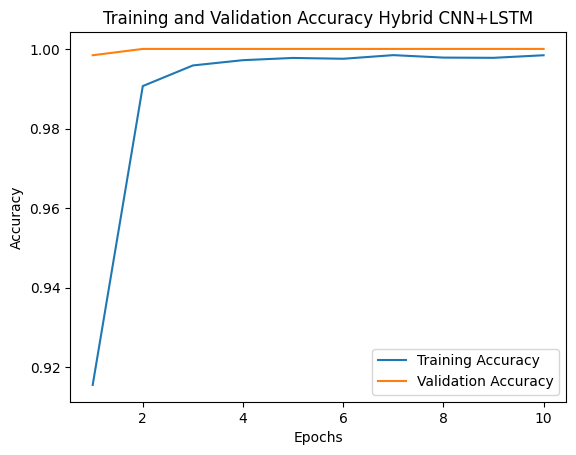

In [ ]:
import matplotlib.pyplot as plt
accuracy_hybrid = history_hybrid_borderline.history['accuracy']
val_accuracy_hybrid = history_hybrid_borderline.history['val_accuracy']
# Plot the loss curves
plt.plot(range(1, len(accuracy_hybrid) + 1), accuracy_hybrid, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_hybrid) + 1), val_accuracy_hybrid, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Hybrid CNN+LSTM')
plt.legend()
plt.show()

69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step


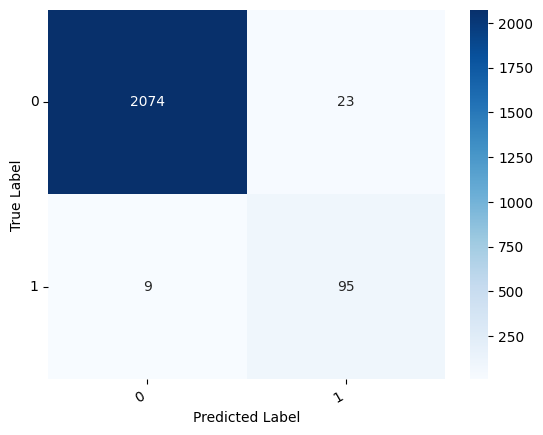

In [ ]:
predictions_hybrid_1 = hybrid_model.predict(x_test_padded1)
predicted_labels_hybrid_1 = (predictions_hybrid_1 > 0.5).astype(int)
cm_hybrid_1 = confusion_matrix(y_test1,predicted_labels_hybrid_1)
show_confusion_matrix(cm_hybrid_1)

####KMeansSMOTE

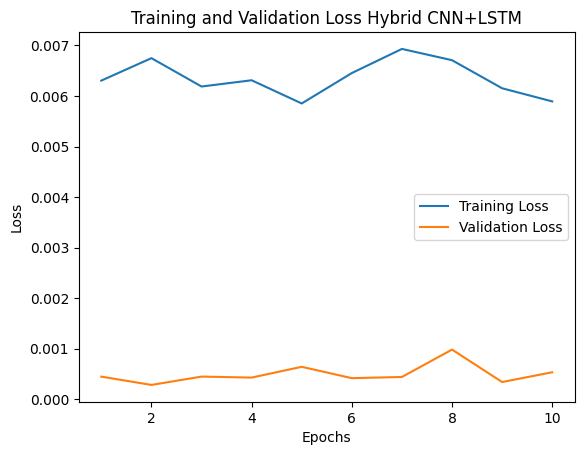

In [ ]:
import matplotlib.pyplot as plt
train_loss_hybrid = history_hybrid_kmeans.history['loss']
val_loss_hybrid = history_hybrid_kmeans.history['val_loss']
# Plot the loss curves
plt.plot(range(1, len(train_loss_hybrid) + 1), train_loss_hybrid, label='Training Loss')
plt.plot(range(1, len(val_loss_hybrid) + 1), val_loss_hybrid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Hybrid CNN+LSTM')
plt.legend()
plt.show()

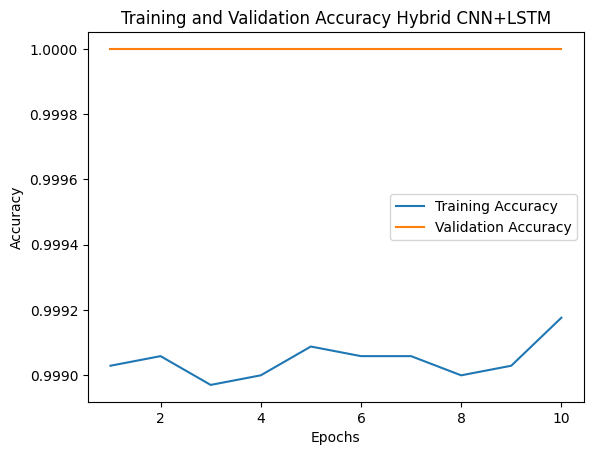

In [ ]:
import matplotlib.pyplot as plt
accuracy_hybrid = history_hybrid_kmeans.history['accuracy']
val_accuracy_hybrid = history_hybrid_kmeans.history['val_accuracy']
# Plot the loss curves
plt.plot(range(1, len(accuracy_hybrid) + 1), accuracy_hybrid, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_hybrid) + 1), val_accuracy_hybrid, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Hybrid CNN+LSTM')
plt.legend()
plt.show()

69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step


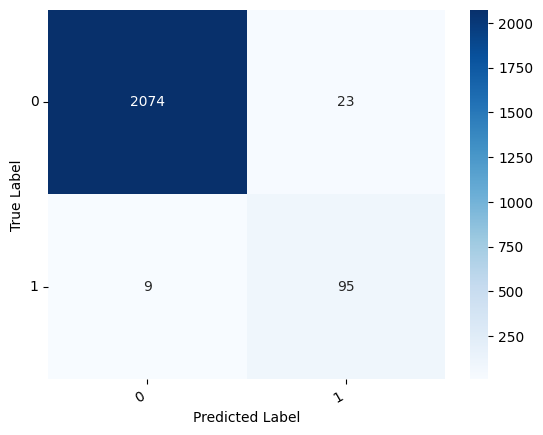

In [ ]:
predictions_hybrid_1 = hybrid_model.predict(x_test_padded1)
predicted_labels_hybrid_1 = (predictions_hybrid_1 > 0.5).astype(int)
cm_hybrid_1 = confusion_matrix(y_test1,predicted_labels_hybrid_1)
show_confusion_matrix(cm_hybrid_1)

####SVMSMOTE

In [ ]:
import matplotlib.pyplot as plt
train_loss_hybrid = history_hybrid_svm.history['loss']
val_loss_hybrid = history_hybrid_svm.history['val_loss']
# Plot the loss curves
plt.plot(range(1, len(train_loss_hybrid) + 1), train_loss_hybrid, label='Training Loss')
plt.plot(range(1, len(val_loss_hybrid) + 1), val_loss_hybrid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Hybrid CNN+LSTM')
plt.legend()
plt.show()

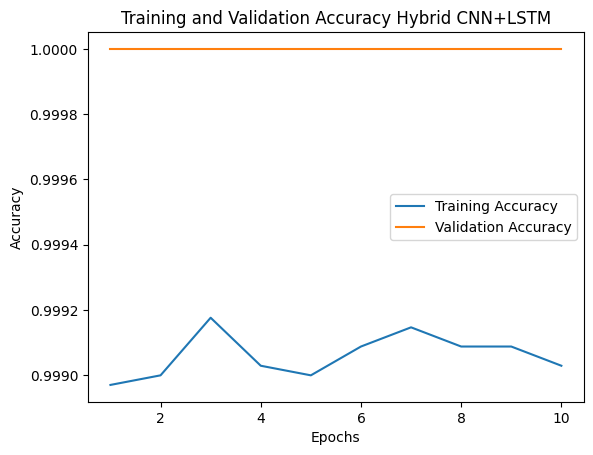

In [ ]:
import matplotlib.pyplot as plt
accuracy_hybrid = history_hybrid_svm.history['accuracy']
val_accuracy_hybrid = history_hybrid_svm.history['val_accuracy']
# Plot the loss curves
plt.plot(range(1, len(accuracy_hybrid) + 1), accuracy_hybrid, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_hybrid) + 1), val_accuracy_hybrid, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Hybrid CNN+LSTM')
plt.legend()
plt.show()

69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step


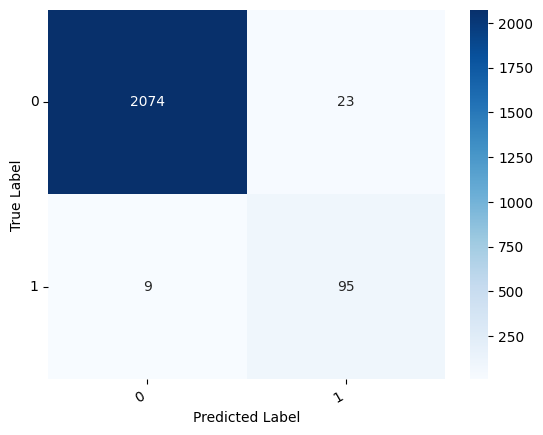

In [ ]:
predictions_hybrid_1 = hybrid_model.predict(x_test_padded1)
predicted_labels_hybrid_1 = (predictions_hybrid_1 > 0.5).astype(int)
cm_hybrid_1 = confusion_matrix(y_test1,predicted_labels_hybrid_1)
show_confusion_matrix(cm_hybrid_1)

In [ ]:
!zip -r CNNLSTMMarginLoss.zip ./* -x "sample_data/*"

  adding: idwiki_word2vec_768_new_lower.model (deflated 72%)
  adding: idwiki_word2vec_768_new_lower.model.syn1neg.npy (deflated 7%)
  adding: idwiki_word2vec_768_new_lower.model.wv.vectors.npy (deflated 7%)
  adding: metrics_hybrid_borderline.csv (deflated 50%)
  adding: metrics_hybrid_kmeans.csv (deflated 55%)
  adding: metrics_hybrid_svm.csv (deflated 55%)
  adding: news_test_clean.csv (deflated 68%)
  adding: news_train_balanced_clean.csv (deflated 65%)
